# vdl: DDPM + Depth and Class Constraints
- **Name:** Nils Fahrni
- **Date:** 07.01.2025

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import numpy as np

np.random.seed(1337)

## Task & Dataset
In this mini challenge I have decided to implement a **denoising diffusion task** according to the [DDPM paper of Ho et al.](https://arxiv.org/pdf/2006.11239) including **conditioning of classes and their average depth**.

The dataset I have used is the [NYU Depth Dataset v2](https://cs.nyu.edu/~fergus/datasets/nyu_depth_v2.html) which stems from the ["Indoor Segmentation and Support Inference
from RGBD Images" paper of Silberman et al.](https://cs.nyu.edu/~fergus/datasets/indoor_seg_support.pdf)

This dataset consists of `1449` densely labeled pairs of RGB and depth images of scenes/rooms at New York University. There are `894` possible classes of entities in each scene. The photographs including depth maps were recorded on a Microsoft Kinect camera. 

### Loading the dataset
I have wrapped the dataset in a `torch.utils.data.Dataset` class for ease of use and compatibility with PyTorch and its Dataloader. The class can be found [here](./data/nyuv2.py), or under `./data/nyuv2.py`.

The `nyuv2.py` dataset wrapper first checks whether the dataset exists in the expected location (`./data/nyu_depth_v2_labeled.mat`). If the file can't be found, it will be automatically downloaded into the `./data/` directory.

After the data got loaded into the class, every item can be accessed with the overridden dunder method `__getitem__`. This method goes through the following process to process the dataset:
1. First, it ensures the data is loaded from the `.mat` structure into the class. 
2. The image, segmentation mask and depth map all get transposed (since the `.mat` matrix representation and numpy/PIL representations have flipped axes) and ultimately put into a `PIL.Image` class.
3. The dataset wrapper takes in optional image, segmentation and depth transformations (such as normalization, resizing, cropping etc.) which can get applied at this point, if defined.
4. All possible unique classes are taken from the segmentation mask. It filters out the background class or "stuff" (`0`) by keeping only classes with values greater than `0`.
    - If `self.filtered_classes` is not defined it creates a `class_vector` and `depth_vector` of length `self.n_classes` (in this case of length `894`). For each unique class in the segmentation mask it shifts the class index by `-1` since class indices start at `1`. It sets the corresponding entry in `class_vector` to 1 to indicate the presence of the class. It calculates the mean depth value for the pixels belonging to that class and stores it in `depth_vector`.
    - If `self.filtered_classes` is present as a vector of clas IDs, it will create the `class_vector` and `depth_vector` only for these given classes. Both these vectors will later on be used to condition the diffusion models.

Additionally, for convenience and interpretability, the `_load_data` method resolves the names of the classes and adds them as a property `resolved_names` to the dataset class. 

## Exploration
First, I load in the dataset with the afforementioned wrapper.

In [3]:
from data.nyuv2 import NYUDepthV2

dataset = NYUDepthV2(root='data', download=True, preload=True)

Dataset already exists, skipping download.


### Looking at Images, Segmentation Masks and Depth Maps
The next step is to look at what the dataset really is made of and what the wrapper produces. The `plot_nyuv2_samples` function plots 5 samples from the dataset.

In [4]:
%%script false --no-raise-error

def plot_nyuv2_samples(dataset, num_rows=5):
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    for i in range(num_rows):
        rgb, seg, depth, _, _ = dataset[i]

        rgb = np.array(rgb).transpose(1, 2, 0) if isinstance(rgb, torch.Tensor) else np.array(rgb)
        seg = np.array(seg)
        depth = np.array(depth)

        unique_classes = np.unique(seg)
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
        color_map = {cls: colors[idx][:3] for idx, cls in enumerate(unique_classes)}

        seg_colored = np.zeros((*seg.shape, 3), dtype=np.float32)
        for cls in unique_classes:
            if cls > 0:
                seg_colored[seg == cls] = color_map[cls]

        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title(f"RGB Image {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(seg_colored)
        axes[i, 1].set_title(f"Segmentation Mask {i+1}")
        axes[i, 1].axis('off')

        handles = [plt.Line2D([0], [0], marker='o', color=color_map[cls], markersize=10, label=dataset.resolved_names[cls - 1]) 
                   for cls in unique_classes if cls > 0]
        axes[i, 1].legend(handles=handles, loc='upper right', fontsize='small', title="Classes")

        depth_img = axes[i, 2].imshow(depth, cmap="viridis")
        axes[i, 2].set_title(f"Depth Map {i+1}")
        axes[i, 2].axis('off')

        cbar = fig.colorbar(depth_img, ax=axes[i, 2], orientation='vertical')
        cbar.set_label("Distance (in Meters)")

    plt.tight_layout()
    plt.show()

plot_nyuv2_samples(dataset, num_rows=5)

Couldn't find program: 'false'


The output shows how versatile the entities of this dataset is. The rooms are filled with a lot of different entities, ranging from seemingly common objects like chairs to a labeled "telephone cord" or even a "tape dispenser". 

Another detail that is visible is that the regular RGB images seem to be slightly tilted and thus contain a white border. This same border can also be seen on both the segmentation masks and the depth maps. The segmentation masks also show a black class, which is the class `0` that gets removed by my implementation of the `nyuv2.py` wrapper - It captures this white border and also edges of objects, which probably is a tool to make instance segmentation easier by clearly introducing this margin/edge/border between objects. 

The depth map shows rather uneven edges, I suspect this is just a cause of the Kinect camera that was used. It is equipped with an infrared sensor which may not be the most accurate option to capture depth.

### Sizes
In this section I want to find out what the actual dimensions of the images, segmentations and depths are.

In [5]:
%%script false --no-raise-error

def check_dataset_sizes(dataset):
    rgb_sizes = []
    seg_sizes = []
    depth_sizes = []

    for i in range(len(dataset)):
        rgb, seg, depth, _, _ = dataset[i]
        if isinstance(rgb, Image.Image):
            rgb_sizes.append(rgb.size[::-1])
        elif isinstance(rgb, torch.Tensor):
            rgb_sizes.append(np.array(rgb).shape)
        else:
            rgb_sizes.append(np.array(rgb).shape)
        
        seg_sizes.append(np.array(seg).shape)
        depth_sizes.append(np.array(depth).shape)

    rgb_unique_sizes = set(rgb_sizes)
    seg_unique_sizes = set(seg_sizes)
    depth_unique_sizes = set(depth_sizes)

    print("Unique RGB Image Sizes:", rgb_unique_sizes)
    print("Unique Segmentation Map Sizes:", seg_unique_sizes)
    print("Unique Depth Map Sizes:", depth_unique_sizes)
    
check_dataset_sizes(dataset)

Couldn't find program: 'false'


The results show that all three dataset components have the same size. This means there are no direct distortions or information loss caused by resizing to match dimensions which is nice.

### White Border
As can be seen in the subsection [Looking at Images, Segmentation Masks and Depth Maps](#looking-at-images-segmentation-masks-and-depth-maps), the images are slightly tilted and the segmentation masks and depth maps have some sort of border. In this subsection I want to prove this observation and find out how much I later on can crop off from images since I don't want the model to learn to generate borders.

In [6]:
%%script false --no-raise-error

def plot_grid_on_black_background(images, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5), facecolor='black')
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.set_facecolor('black')
            ax.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

random_indices = np.random.choice(len(dataset), 6)
images = [dataset[i][0] for i in random_indices]
plot_grid_on_black_background(images, rows=2, cols=3)

Couldn't find program: 'false'


The randomly sampled images all show a white border as expected.

In [7]:
%%script false --no-raise-error

def test_different_crops(dataset, crop_sizes, n_samples=4):
    fig, axes = plt.subplots(n_samples, len(crop_sizes), figsize=(10, 2 * n_samples), facecolor='black')
    if n_samples == 1:
        axes = [axes]
    
    for row in range(n_samples):
        image, _, _, _, _ = dataset[row]
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        elif not isinstance(image, Image.Image):
            raise TypeError("Dataset must provide a PIL Image or a Tensor as the first item.")

        for col, crop_size in enumerate(crop_sizes):
            crop_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.CenterCrop(crop_size),
                transforms.ToPILImage()
            ])
            cropped_image = crop_transform(image)

            axes[row][col].imshow(cropped_image)
            axes[row][col].set_title(f"Cropping {crop_size}px", color='white')
            axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()

crop_sizes = [480, 440, 400, 360, 320]
test_different_crops(dataset, crop_sizes, n_samples=4)

Couldn't find program: 'false'


After only keeping `480px` on both the y and x axis I still get some white border since the white border goes around the entire image. At `440px` the border seems to not be visible anymore on these samples.

### Resizing
After cropping I look at resizing in this section. With a resolution of `640x480` (or after cropping `400x400`) the images are quite large and will take up much memory. To explore on how much I can reduce the images to still identify the scenes the following plot should help to identify that size.

In [8]:
%%script false --no-raise-error

def plot_dataset_with_different_resizes(dataset, resize_sizes, n_samples=4):
    fig, axes = plt.subplots(n_samples, len(resize_sizes), figsize=(10, 2 * n_samples))
    if n_samples == 1:
        axes = [axes]
    
    for row in range(n_samples):
        image, _, _, _, _ = dataset[row]
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        elif not isinstance(image, Image.Image):
            raise TypeError("Dataset must provide a PIL Image or a Tensor as the first item.")

        for col, resize_size in enumerate(resize_sizes):
            resize_transform = transforms.Compose([
                transforms.CenterCrop(400),
                transforms.ToTensor(),
                transforms.Resize(resize_size),
                transforms.ToPILImage()
            ])
            resized_image = resize_transform(image)

            axes[row][col].imshow(resized_image)
            axes[row][col].set_title(f"Resize: {resize_size}")
            axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()
    
resize_sizes = [256, 128, 64, 32]
plot_dataset_with_different_resizes(dataset, resize_sizes, n_samples=4)

Couldn't find program: 'false'


The lowest possible size I would go with is `64x64`. The samples with that size seem to still show the general scenes and entities in a recognizable manner.

### Classes
At this point there are still 894 classes. This will most likely be too many to condition a diffusion model with just 1449 samples. The goal in this subsection is to see what the most common classes are. Based on that I will make a smaller selection of classes I will later condition the models on.

In [72]:
%%script false --no-raise-error

class_occurrences = defaultdict(int)

for _, seg, _, _, _ in dataset:
    for c in torch.unique(torch.tensor(seg)):
        class_occurrences[c.item()] += 1
        
class_occurrences.pop(0, None) # removing the background/edge class

1449

Text(0.5, 1.0, 'Number of occurrences of each class in the dataset')

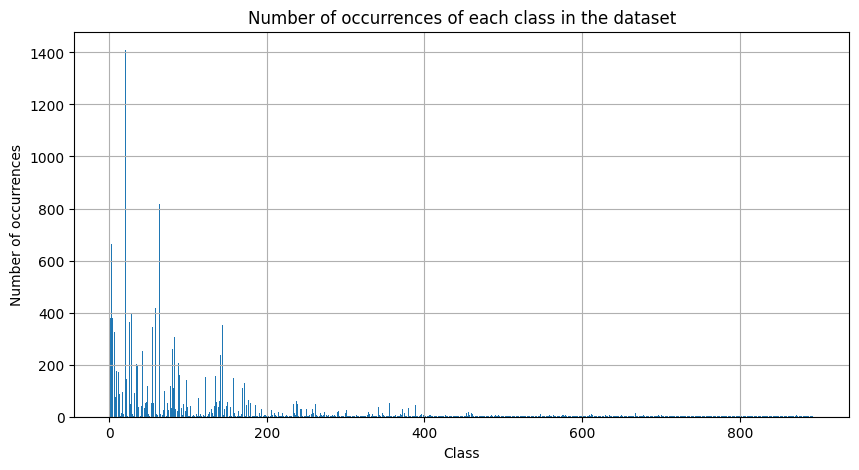

In [61]:
%%script false --no-raise-error

plt.figure(figsize=(10, 5))
plt.bar(class_occurrences.keys(), class_occurrences.values())
plt.grid(True)
plt.xlabel('Class')
plt.ylabel('Number of occurrences')
plt.title('Number of occurrences of each class in the dataset')

There are a lot of classes within the right tail of the histogram with just one single occurence. To generate these objects, the model would have to overfit on these. Additionally, if we split up the dataset into train, test and validation partitions, we will not be able to have at least one sample with such a class in each partition.

To get a grasp of what kind of classes occur most and least commonly, the following block shows both ends:

In [62]:
%%script false --no-raise-error

sorted_classes = sorted(class_occurrences, key=lambda x: class_occurrences[x], reverse=True)

sorted_classes = [c - 1 for c in sorted_classes]

print(f'5 Most common classes: {dataset.resolved_names[sorted_classes[:5]]}')
print(f'5 Least common classes: {dataset.resolved_names[sorted_classes[-5:]]}')

5 Most common classes: ['wall' 'floor' 'picture' 'cabinet' 'chair']
5 Least common classes: ['sewing machine' 'rolled up rug' 'doily' 'coffee pot' 'torah']


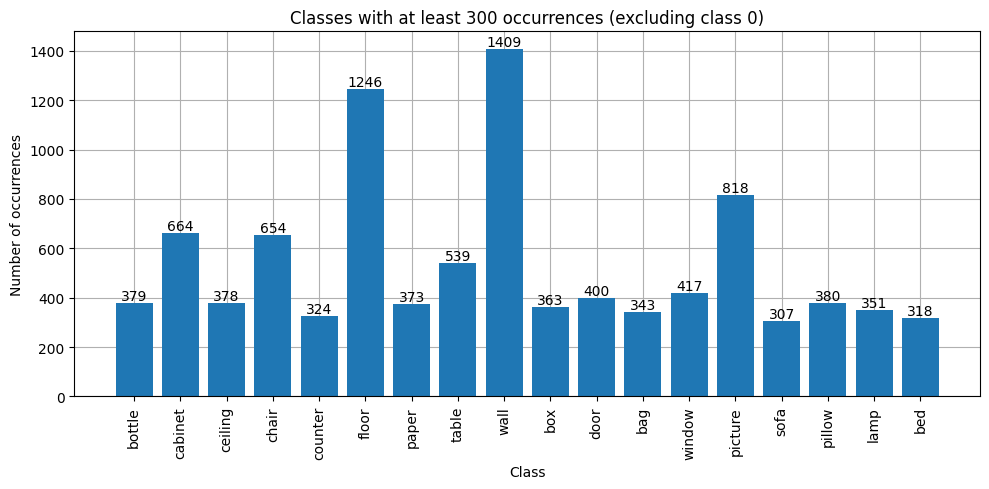

In [73]:
%%script false --no-raise-error

LEAST_N_SAMPLES = 300

plt.figure(figsize=(10, 5))

filtered_classes = [k for k, v in class_occurrences.items() if v >= LEAST_N_SAMPLES and k != 0]
filtered_counts = [v for k, v in class_occurrences.items() if v >= LEAST_N_SAMPLES and k != 0]

x_positions = range(len(filtered_classes))

resolved_labels = [dataset.resolved_names[k-1] for k in filtered_classes]

bars = plt.bar(x_positions, filtered_counts, zorder=2)
plt.grid(True, zorder=1)
plt.xticks(x_positions, resolved_labels, rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of occurrences')
plt.title(f'Classes with at least {LEAST_N_SAMPLES} occurrences (excluding class 0)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [66]:
%%script false --no-raise-error

filtered_classes

[2, 3, 4, 5, 7, 11, 15, 19, 21, 26, 28, 55, 59, 64, 83, 119, 144, 157]

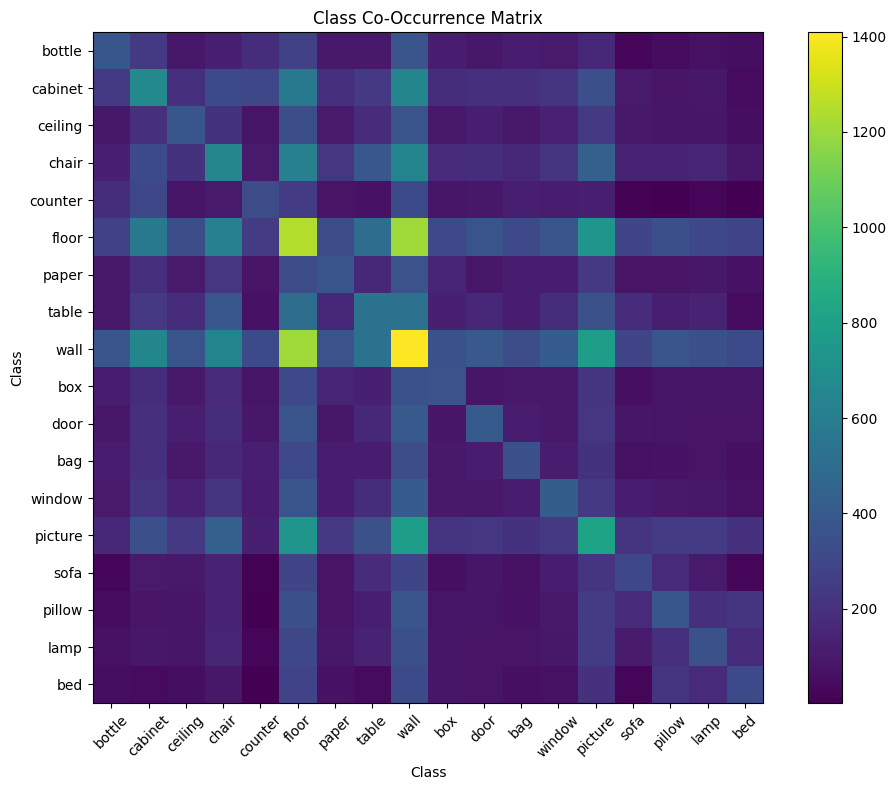

In [80]:
%%script false --no-raise-error

def compute_co_occurrence_matrix(dataset, class_ids):
    class_ids = sorted(list(set(class_ids)))
    class_to_index = {c: i for i, c in enumerate(class_ids)}

    num_classes = len(class_ids)
    co_occurrence_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for _, seg, _, _, _ in dataset:
        seg_tensor = torch.tensor(seg)

        unique_classes = torch.unique(seg_tensor).tolist()

        filtered_classes = [c for c in unique_classes if c in class_to_index]

        for i in range(len(filtered_classes)):
            for j in range(i, len(filtered_classes)):
                c1, c2 = filtered_classes[i], filtered_classes[j]
                idx1, idx2 = class_to_index[c1], class_to_index[c2]
                co_occurrence_matrix[idx1, idx2] += 1
                if idx1 != idx2:
                    co_occurrence_matrix[idx2, idx1] += 1

    return co_occurrence_matrix

class_ids = [2, 3, 4, 5, 7, 11, 15, 19, 21, 26, 28, 55, 59, 64, 83, 119, 144, 157]
co_matrix = compute_co_occurrence_matrix(dataset, class_ids)

plt.figure(figsize=(10, 8))
plt.imshow(co_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.xticks(ticks=range(len(class_ids)), labels=resolved_labels, rotation=45)
plt.yticks(ticks=range(len(class_ids)), labels=resolved_labels)
plt.xlabel('Class')
plt.ylabel('Class')
plt.title('Class Co-Occurrence Matrix')
plt.tight_layout()
plt.show()

### Colors

Dataset already exists, skipping download.


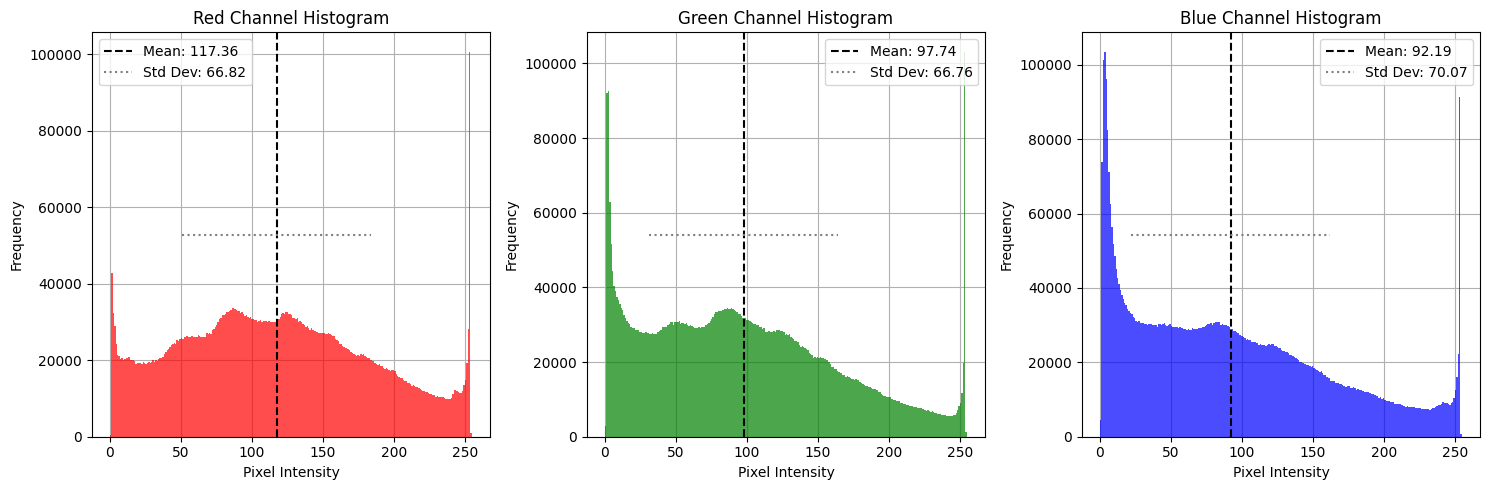

Mean: [117.3629257381168, 97.74075365823413, 92.18869205998749]
Mean (Normalized): [0.460246767600458, 0.3832970731695456, 0.36152428258818625]
Standard Deviation: [66.82024631875879, 66.76032200388126, 70.06545212250501]
Standard Deviation (Normalized): [0.26204018164219134, 0.2618051843289461, 0.27476647891178435]


In [12]:
def plot_rgb_histograms(dataset):
    red_channel = []
    green_channel = []
    blue_channel = []

    for image, _, _, _, _ in dataset:
        image_array = np.array(image)

        red_channel.extend(image_array[:, :, 0].flatten())
        green_channel.extend(image_array[:, :, 1].flatten())
        blue_channel.extend(image_array[:, :, 2].flatten())

    means = np.array([
        np.mean(red_channel),
        np.mean(green_channel),
        np.mean(blue_channel)
    ])
    stds = np.array([
        np.std(red_channel),
        np.std(green_channel),
        np.std(blue_channel)
    ])

    plt.figure(figsize=(15, 5))

    for i, (color, channel, mean, std) in enumerate(zip(
        ['Red', 'Green', 'Blue'],
        [red_channel, green_channel, blue_channel],
        means, stds
    )):
        plt.subplot(1, 3, i + 1)
        plt.hist(channel, bins=256, color=color.lower(), alpha=0.7, zorder=2)
        plt.title(f'{color} Channel Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.grid(True, zorder=1)

        center_y = plt.gca().get_ylim()[1] / 2

        plt.axvline(mean, color='black', linestyle='dashed', linewidth=1.5, label=f"Mean: {mean:.2f}")
        plt.hlines(center_y, mean - std, mean + std, color='gray', linestyle='dotted', linewidth=1.5, label=f"Std Dev: {std:.2f}")

        plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Mean: {means.tolist()}")
    print(f"Mean (Normalized): {(means / 255).tolist()}")
    print(f"Standard Deviation: {stds.tolist()}")
    print(f"Standard Deviation (Normalized): {(stds / 255).tolist()}")

cropped_dataset = NYUDepthV2(root='data', 
                             download=True, 
                             preload=True, 
                             image_transform=transforms.Compose([
                                                 transforms.CenterCrop(400),
                                                 transforms.Resize(64)
                                             ]))

plot_rgb_histograms(cropped_dataset)

The red channel has a higher mean intensity compared to green and blue. I suppose this makes sense for the images which depict rooms since they rather show warmer tones.
The peaks at 0 and 255 across all channels imply the presence of underexposed (dark) areas and overexposed (bright) regions due to lighting conditions in the rooms.

The standard deviations and means of each channel will be used to standardize the image inputs.

## Diffusion Scheduler
Next to the models, the **Diffusion Scheduler** is one of the main components of this project.

In [13]:
from diffusion import Diffusion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffusion = Diffusion(
    noise_steps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    img_size=64,
    device=device
)



## Training Setup

## Dataset Preparation

- 894 classes -> 18 classes

In [1]:
from data.nyuv2 import NYUDepthV2
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

mean = [0.5105, 0.4662, 0.4438]
std = [0.2273, 0.2275, 0.2409]

image_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

crop_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
])

dataset = NYUDepthV2(root='data', 
                     download=True, 
                     preload=False, 
                     image_transform=image_t, 
                     seg_transform=crop_t, 
                     depth_transform=crop_t, 
                     filtered_classes=[5, 11, 21, 26, 2, 3, 7, 64, 144, 19, 119, 157, 28, 55, 15, 59, 4, 83])

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

Dataset already exists, skipping download.


In [2]:
from data import split_dataset

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tensor([1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.])
tensor([3.7134, 3.7134, 0.0000, 3.7134, 3.7134, 0.0000, 3.7134, 3.7134, 3.7134,
        0.0000, 3.7134, 3.7134, 0.0000, 0.0000, 3.7134, 3.7134, 3.7134, 0.0000])


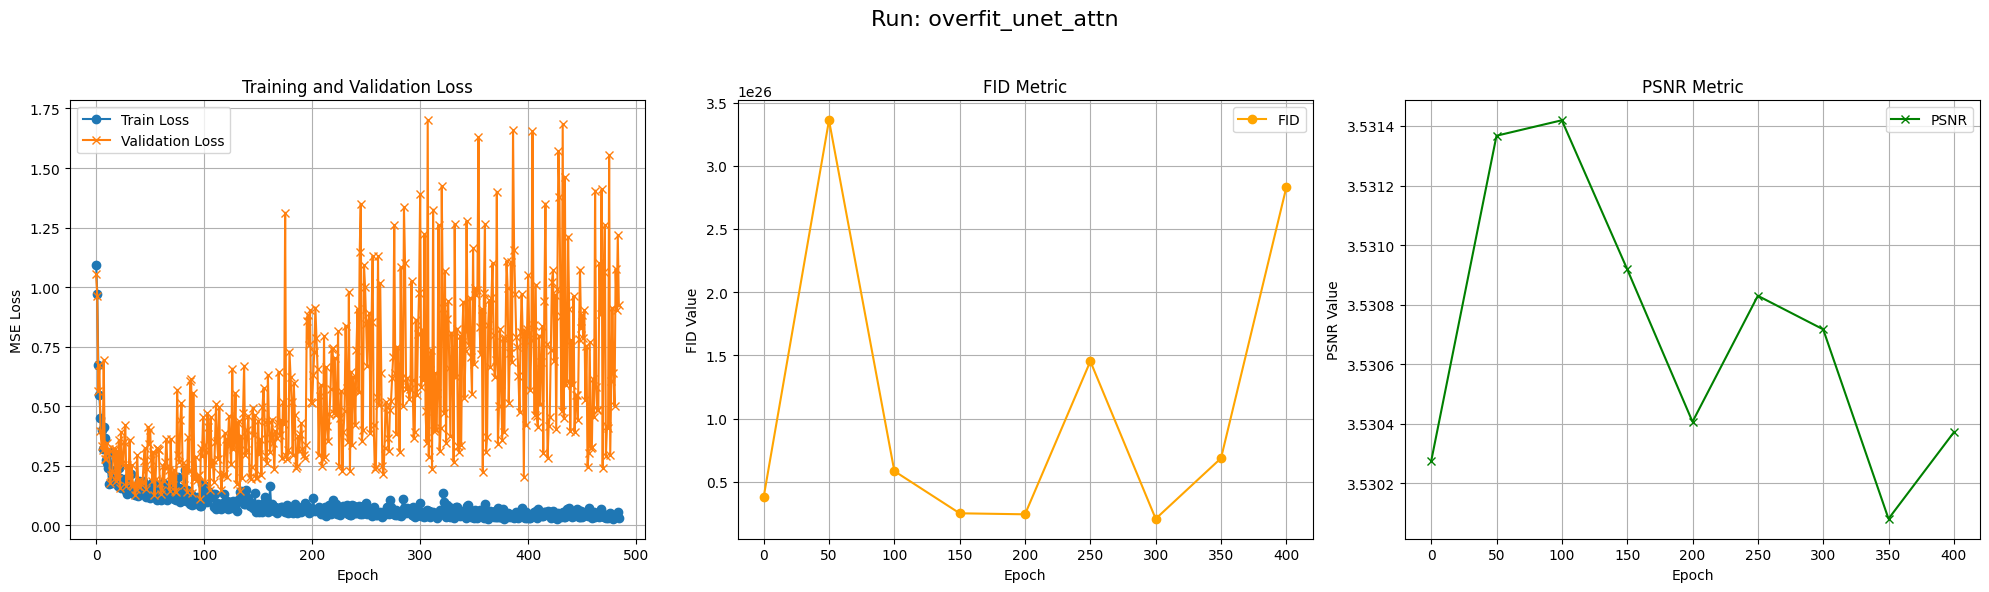

--- Model Receipt for UNet_Attn ---

Training Time: 2.00 hours
Total parameters: 23539331
Trainable parameters: 23539331
Non-trainable parameters: 0
Device: cuda:0

Model Architecture:

UNet_Attn(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=

01:25:12 - INFO: Sampling 5 new images from UNet_Attn...
999it [00:54, 18.19it/s]
01:26:07 - INFO: Sampling 5 new images from UNet_Attn...
999it [01:09, 14.43it/s]


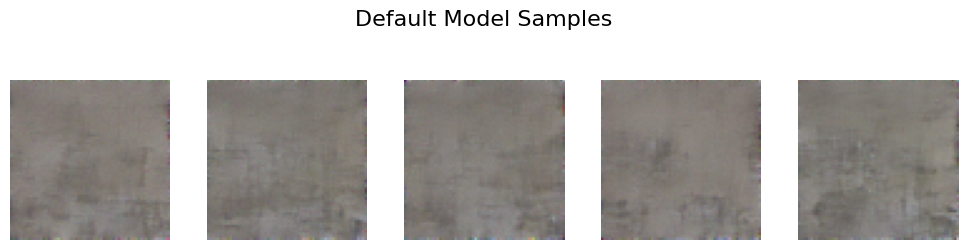

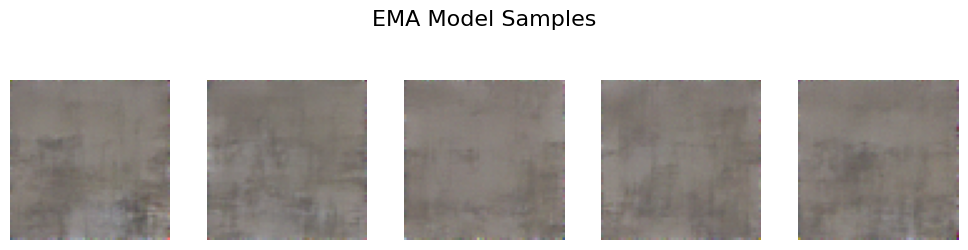

In [50]:
from analyzer import Analyzer

class_vec = torch.randint(0, 2, (18,), dtype=torch.float32)
# create depth vector of size 18 and put random numbers where class vector is 1
depth_vec = torch.zeros(18, dtype=torch.float32)
# random depth float value between 1 and 5
random_depth_value = torch.rand(1) * 4 + 1
depth_vec[class_vec == 1] = random_depth_value

analyzer = Analyzer(model, device)
analyzer.plot('k82fjz9d')
analyzer.model_receipt()
analyzer.sample_images('k82fjz9d', class_vec, depth_vec)

## Modules

In [5]:
from core import UNet_Baseline
from core import UNet_Attn

# Instantiate the model
baseline = UNet_Baseline(num_classes=18, device=device).to(device)
attn = UNet_Attn(num_classes=18, device=device).to(device)

# Dummy inputs
x = torch.randn(1, 3, 64, 64).to(device)
t = torch.randint(0, 1000, (x.shape[0],)).to(device)
class_vector = torch.ones((x.shape[0], 18)).to(device)
depth_vector = torch.zeros((x.shape[0], 18)).to(device)

for net in [baseline, attn]:
    output = net(x, t, class_vector, depth_vector)
    print(f'--- Model: {net.__class__.__name__} ---')
    print(f"Total parameters: {sum(p.numel() for p in net.parameters())}")
    print(f'Input shape: {x.shape}')
    print(f"Output shape: {output.shape}")
    print()

--- Model: UNet_Baseline ---
Total parameters: 1771907
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])

--- Model: UNet_Attn ---
Total parameters: 23539331
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])



## Diffusion

In [6]:
from diffusion import Diffusion

## Trainer

In [7]:
from trainer import Trainer

In [94]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset[:24], train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Training samples: 16
Validation samples: 4
Testing samples: 4


In [96]:
from core import UNet_Attn
# import copy here
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet_Attn(num_classes=18, dropout_prob=0.2, device=device).to(device)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

ema_model.load_state_dict(torch.load('models/unet_attn_dropout_0.2_ema_o6mtkrvr.pth', map_location=device))

C:\Users\fahrn\AppData\Local\Temp\ipykernel_21016\74155036.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ema_model.load_state_dict(torch.load('models/unet_attn_dropou

<All keys matched successfully>

In [135]:
# a 894-dimensional class vector with some 1s and 0s
class_vector = torch.tensor(dataset[0][3]).unsqueeze(0)
depth_vector = torch.tensor(dataset[0][4]).unsqueeze(0)

dataset.resolved_names 

class_vector = torch.tensor([0]*18)
print(dataloader.dataset.resolved_names)

class_vector[0] = 1
class_vector[15] = 1

depth_vector = torch.tensor([0]*18)
depth_vector[0] = 1.3
depth_vector[15] = 3.0

['chair' 'floor' 'wall' 'box' 'bottle' 'cabinet' 'counter' 'picture'
 'lamp' 'table' 'pillow' 'bed' 'door' 'bag' 'paper' 'window' 'ceiling'
 'sofa']


In [136]:
depth_vector

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0])

In [117]:
# vector of rand int between 0 and 1000
t = torch.randint(0, 2, (18,))
t

tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')

In [11]:
class_vector.shape, depth_vector.shape

(torch.Size([18]), torch.Size([18]))

In [162]:
class_vec = torch.randint(0, 2, (18,), dtype=torch.float32)
# create depth vector of size 18 and put random numbers where class vector is 1
depth_vec = torch.zeros(18, dtype=torch.float32)
# random depth float value between 1 and 5
random_depth_value = torch.rand(1) * 4 + 1
depth_vec[class_vec == 1] = random_depth_value

class_vec, depth_vec

(tensor([1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.]),
 tensor([3.5020, 3.5020, 0.0000, 3.5020, 3.5020, 0.0000, 0.0000, 3.5020, 0.0000,
         3.5020, 0.0000, 3.5020, 3.5020, 3.5020, 0.0000, 0.0000, 0.0000, 0.0000]))

In [151]:
dataset[0][3].shape, depth_vec.shape

((18,), torch.Size([18]))

In [168]:
torch.randn((5,18))

tensor([[-1.3699, -1.3499,  0.2956, -0.2121, -1.0645, -0.2529,  0.1801,  0.8034,
         -0.5629,  1.1299, -0.1499,  1.6647,  0.4075, -0.8150, -0.5623,  0.8271,
          0.8679,  1.7021],
        [ 0.6759, -0.3045,  0.0482,  1.1407,  1.0915, -0.1082,  0.9176, -1.2093,
          0.3622, -0.6764,  0.1202,  0.2775, -1.0146,  1.2761,  1.0258, -0.7102,
         -0.3212,  0.6506],
        [-0.2277, -0.0103, -1.0557,  0.1271,  1.4329, -0.3883, -0.7710, -0.1681,
          0.6162, -0.0086, -1.0318, -0.2279,  0.3163,  0.1782, -1.2993, -0.7808,
          0.8477, -0.4030],
        [ 0.9612,  0.3948, -0.4251, -0.7046,  1.1402,  0.1000,  1.6556,  0.7505,
         -0.8409,  0.2214,  0.5243,  0.3529, -1.5270, -0.3965,  0.3960,  0.4018,
          0.1686, -0.8878],
        [-1.5587,  0.0707,  0.5291, -1.3588, -1.3615, -0.1360,  0.4712, -0.6185,
         -0.6138,  0.3171, -0.3423, -0.0232, -0.1501, -0.5206, -1.0282, -1.4857,
          0.9477,  0.8803]])

In [176]:
diffusion = Diffusion(beta_start=0.0001, beta_end=0.002, device=device)

sampled_images = diffusion.sample(ema_model, 5, torch.randn((5,18)).to(device), torch.randn(5,18).to(device))

05:34:32 - INFO: Sampling 5 new images from UNet_Attn...
999it [00:58, 17.17it/s]


05:51:22 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6846166..0.5138063].


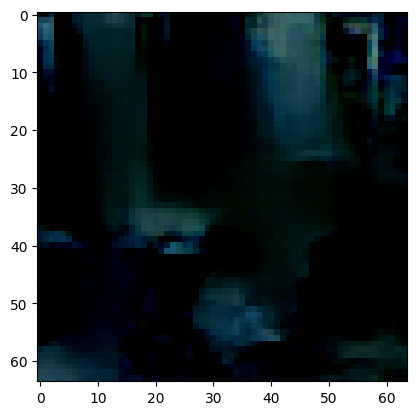

In [181]:
from data import unnormalize

plt.imshow(sampled_images[3].cpu().permute(1, 2, 0))
plt.show()

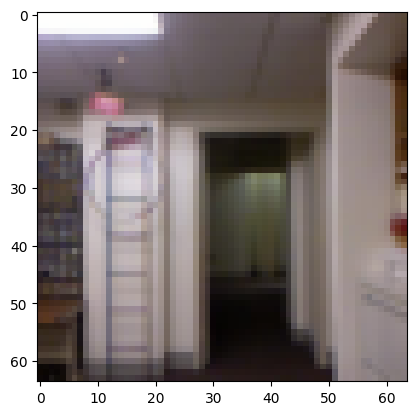

In [16]:
plt.imshow(unnormalize(train_dataset[1][0], mean, std).permute(1, 2, 0))

In [17]:
plot_image(sampled_images[0], mean, std, value_range="[0, 1]")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.